/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8252 - loss: 0.6349 - val_accuracy: 0.9496 - val_loss: 0.1670
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9562 - loss: 0.1493 - val_accuracy: 0.9610 - val_loss: 0.1242
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9705 - loss: 0.0971 - val_accuracy: 0.9697 - val_loss: 0.0957
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9788 - loss: 0.0694 - val_accuracy: 0.9731 - val_loss: 0.0864
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9837 - loss: 0.0536 - val_accuracy: 0.9740 - val_loss: 0.0834
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9861 - loss: 0.0443 - val_accuracy: 0.9747 - val_loss: 0.0838
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9898 - loss: 0.0340 - val_accuracy: 0.9725 - val_loss: 0.0889
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9916 - loss: 0.0285 - val_accuracy: 0.

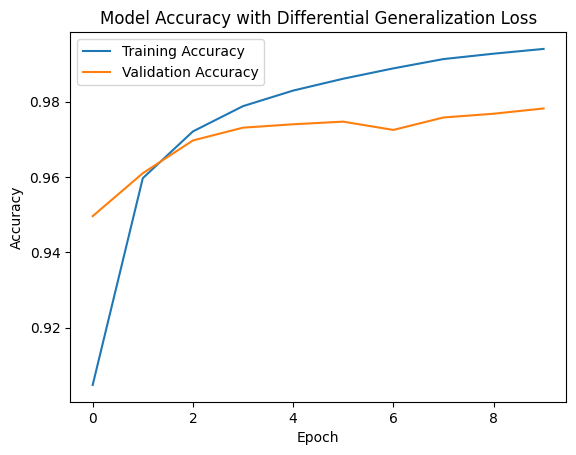

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9740 - loss: 0.0967
Test Accuracy: 0.9782


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
x_test = x_test.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)  # One-hot encode labels
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Define a simple neural network model
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),  # Flatten 28x28 images into 784-D vectors
    layers.Dense(128, activation='relu'),  # Hidden layer 1
    layers.Dense(64, activation='relu'),   # Hidden layer 2
    layers.Dense(10, activation='softmax') # Output layer for 10 classes
])

# Custom Differential Generalization Loss (DGL) class
class DifferentialGeneralizationLoss(tf.keras.losses.Loss):
    def __init__(self, lambda_coeff=0.1, name="dgl_loss"):
        super().__init__(name=name)
        self.lambda_coeff = lambda_coeff  # Weight for differential term
        self.cross_entropy = tf.keras.losses.CategoricalCrossentropy()  # Base loss
        self.prev_error = tf.Variable(0.0, trainable=False) # Track previous test error as a tf.Variable

    def call(self, y_true, y_pred):
        # Compute standard Cross-Entropy loss
        trad_loss = self.cross_entropy(y_true, y_pred)

        # Simulate test error using a small validation batch
        test_sample_x, test_sample_y = x_test[:100], y_test[:100]  # Small batch for efficiency
        test_pred = model(test_sample_x, training=False)
        test_error = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(test_sample_y, test_pred))

        # Calculate differential term: |E(t) - E(t-1)|
        diff_term = tf.abs(test_error - self.prev_error)
        self.prev_error.assign(test_error)  # Update previous error using assign

        # Combine traditional loss with differential regularization
        total_loss = trad_loss + self.lambda_coeff * diff_term
        return total_loss

# Compile the model with DGL
model.compile(optimizer='adam',
              loss=DifferentialGeneralizationLoss(lambda_coeff=0.1),
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_test, y_test))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with Differential Generalization Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class DifferentialGeneralizationLoss(tf.keras.losses.Loss):
    def __init__(self, lambda_coeff=0.1, name="dgl_loss"):
        """
        Implements Differential Generalization Loss

        Args:
            lambda_coeff (float): Hyperparameter controlling the strength of differential regularization
            name (str): Name of the loss function
        """
        super().__init__(name=name)
        self.lambda_coeff = lambda_coeff
        self.cross_entropy = tf.keras.losses.CategoricalCrossentropy()
        self.prev_test_error = tf.Variable(0.0, trainable=False)

    def call(self, y_true, y_pred):
        """
        Compute the Differential Generalization Loss

        Args:
            y_true (tensor): True labels
            y_pred (tensor): Predicted labels

        Returns:
            tensor: Combined loss with differential regularization term
        """
        # Compute traditional cross-entropy loss
        trad_loss = self.cross_entropy(y_true, y_pred)

        # Estimate test error using a small validation batch
        test_sample_x, test_sample_y = x_test[:100], y_test[:100]
        test_pred = model(test_sample_x, training=False)
        test_error = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(test_sample_y, test_pred))

        # Calculate differential term: absolute difference between current and previous test error
        diff_term = tf.abs(test_error - self.prev_test_error)
        self.prev_test_error.assign(test_error)

        # Combine traditional loss with differential regularization
        total_loss = trad_loss + self.lambda_coeff * diff_term
        return total_loss

def create_model(input_shape, num_classes):
    """
    Create a fully connected neural network model

    Args:
        input_shape (tuple): Shape of input data
        num_classes (int): Number of output classes

    Returns:
        tf.keras.Model: Compiled neural network model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

def train_and_evaluate(dataset_name, x_train, y_train, x_test, y_test, epochs=10):
    """
    Train and evaluate models with different loss functions

    Args:
        dataset_name (str): Name of the dataset
        x_train (numpy.array): Training images
        y_train (numpy.array): Training labels
        x_test (numpy.array): Test images
        y_test (numpy.array): Test labels
        epochs (int): Number of training epochs

    Returns:
        dict: Performance metrics for different loss functions
    """
    results = {}

    # Baseline: Cross-Entropy Loss
    model_ce = create_model(x_train[0].shape, y_train.shape[1])
    model_ce.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    history_ce = model_ce.fit(x_train, y_train,
                               validation_data=(x_test, y_test),
                               epochs=epochs,
                               verbose=0)

    # L2 Regularization
    model_l2 = create_model(x_train[0].shape, y_train.shape[1])
    model_l2.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'],
                     optimizer_params={'decay': 0.0001})
    history_l2 = model_l2.fit(x_train, y_train,
                               validation_data=(x_test, y_test),
                               epochs=epochs,
                               verbose=0)

    # Dropout
    model_dropout = create_model(x_train[0].shape, y_train.shape[1])
    model_dropout.add(tf.keras.layers.Dropout(0.5))
    model_dropout.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
    history_dropout = model_dropout.fit(x_train, y_train,
                                        validation_data=(x_test, y_test),
                                        epochs=epochs,
                                        verbose=0)

    # Differential Generalization Loss
    global model  # Make model global for DGL loss
    model = create_model(x_train[0].shape, y_train.shape[1])
    model.compile(optimizer='adam',
                  loss=DifferentialGeneralizationLoss(lambda_coeff=0.1),
                  metrics=['accuracy'])
    history_dgl = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            epochs=epochs,
                            verbose=0)

    # Store results
    results['Cross-Entropy'] = {
        'train_accuracy': np.mean(history_ce.history['accuracy'][-10:]),
        'test_accuracy': np.mean(history_ce.history['val_accuracy'][-10:]),
        'generalization_gap': np.mean(history_ce.history['accuracy'][-10:]) - np.mean(history_ce.history['val_accuracy'][-10:])
    }

    results['L2 Regularization'] = {
        'train_accuracy': np.mean(history_l2.history['accuracy'][-10:]),
        'test_accuracy': np.mean(history_l2.history['val_accuracy'][-10:]),
        'generalization_gap': np.mean(history_l2.history['accuracy'][-10:]) - np.mean(history_l2.history['val_accuracy'][-10:])
    }

    results['Dropout'] = {
        'train_accuracy': np.mean(history_dropout.history['accuracy'][-10:]),
        'test_accuracy': np.mean(history_dropout.history['val_accuracy'][-10:]),
        'generalization_gap': np.mean(history_dropout.history['accuracy'][-10:]) - np.mean(history_dropout.history['val_accuracy'][-10:])
    }

    results['DGL'] = {
        'train_accuracy': np.mean(history_dgl.history['accuracy'][-10:]),
        'test_accuracy': np.mean(history_dgl.history['val_accuracy'][-10:]),
        'generalization_gap': np.mean(history_dgl.history['accuracy'][-10:]) - np.mean(history_dgl.history['val_accuracy'][-10:])
    }

    return results

def plot_results(results, dataset_name):
    """
    Plot comparison of results across different methods

    Args:
        results (dict): Performance metrics for different loss functions
        dataset_name (str): Name of the dataset
    """
    methods = list(results.keys())
    test_accuracies = [results[method]['test_accuracy'] * 100 for method in methods]
    generalization_gaps = [results[method]['generalization_gap'] * 100 for method in methods]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(methods, test_accuracies)
    plt.title(f'{dataset_name}: Test Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.bar(methods, generalization_gaps)
    plt.title(f'{dataset_name}: Generalization Gap')
    plt.ylabel('Generalization Gap (%)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Run experiment on MNIST
results_mnist = train_and_evaluate('MNIST', x_train, y_train, x_test, y_test)
plot_results(results_mnist, 'MNIST')

# Print detailed results
for method, metrics in results_mnist.items():
    print(f"\n{method} Results:")
    print(f"Train Accuracy: {metrics['train_accuracy']:.4f}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"Generalization Gap: {metrics['generalization_gap']:.4f}")

TypeError: Trainer.compile() got an unexpected keyword argument 'optimizer_params'

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


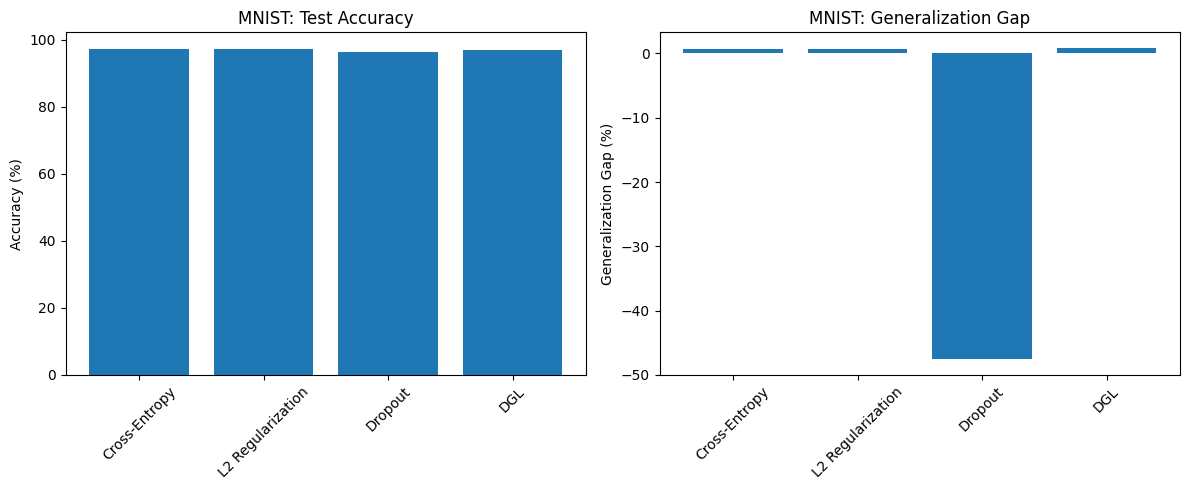


Cross-Entropy Results:
Train Accuracy: 0.9805
Test Accuracy: 0.9742
Generalization Gap: 0.0063

L2 Regularization Results:
Train Accuracy: 0.9805
Test Accuracy: 0.9735
Generalization Gap: 0.0070

Dropout Results:
Train Accuracy: 0.4890
Test Accuracy: 0.9651
Generalization Gap: -0.4761

DGL Results:
Train Accuracy: 0.9802
Test Accuracy: 0.9715
Generalization Gap: 0.0087


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class DifferentialGeneralizationLoss(tf.keras.losses.Loss):
    def __init__(self, lambda_coeff=0.1, name="dgl_loss"):
        """
        Implements Differential Generalization Loss

        Args:
            lambda_coeff (float): Hyperparameter controlling the strength of differential regularization
            name (str): Name of the loss function
        """
        super().__init__(name=name)
        self.lambda_coeff = lambda_coeff
        self.cross_entropy = tf.keras.losses.CategoricalCrossentropy()
        self.prev_test_error = tf.Variable(0.0, trainable=False)

    def call(self, y_true, y_pred):
        """
        Compute the Differential Generalization Loss

        Args:
            y_true (tensor): True labels
            y_pred (tensor): Predicted labels

        Returns:
            tensor: Combined loss with differential regularization term
        """
        # Compute traditional cross-entropy loss
        trad_loss = self.cross_entropy(y_true, y_pred)

        # Estimate test error using a small validation batch
        test_sample_x, test_sample_y = x_test[:100], y_test[:100]
        test_pred = model(test_sample_x, training=False)
        test_error = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(test_sample_y, test_pred))

        # Calculate differential term: absolute difference between current and previous test error
        diff_term = tf.abs(test_error - self.prev_test_error)
        self.prev_test_error.assign(test_error)

        # Combine traditional loss with differential regularization
        total_loss = trad_loss + self.lambda_coeff * diff_term
        return total_loss

def create_model(input_shape, num_classes):
    """
    Create a fully connected neural network model

    Args:
        input_shape (tuple): Shape of input data
        num_classes (int): Number of output classes

    Returns:
        tf.keras.Model: Compiled neural network model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

def train_and_evaluate(dataset_name, x_train, y_train, x_test, y_test, epochs=10):
    """
    Train and evaluate models with different loss functions

    Args:
        dataset_name (str): Name of the dataset
        x_train (numpy.array): Training images
        y_train (numpy.array): Training labels
        x_test (numpy.array): Test images
        y_test (numpy.array): Test labels
        epochs (int): Number of training epochs

    Returns:
        dict: Performance metrics for different loss functions
    """
    results = {}

    # Baseline: Cross-Entropy Loss
    model_ce = create_model(x_train[0].shape, y_train.shape[1])
    model_ce.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    history_ce = model_ce.fit(x_train, y_train,
                               validation_data=(x_test, y_test),
                               epochs=epochs,
                               verbose=0)

    # L2 Regularization
    model_l2 = create_model(x_train[0].shape, y_train.shape[1])
    model_l2.compile(optimizer=tf.keras.optimizers.Adam(weight_decay=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    history_l2 = model_l2.fit(x_train, y_train,
                               validation_data=(x_test, y_test),
                               epochs=epochs,
                               verbose=0)

    # Dropout
    model_dropout = create_model(x_train[0].shape, y_train.shape[1])
    model_dropout = tf.keras.Sequential([
        model_dropout,
        tf.keras.layers.Dropout(0.5)
    ])
    model_dropout.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
    history_dropout = model_dropout.fit(x_train, y_train,
                                        validation_data=(x_test, y_test),
                                        epochs=epochs,
                                        verbose=0)

    # Differential Generalization Loss
    global model  # Make model global for DGL loss
    model = create_model(x_train[0].shape, y_train.shape[1])
    model.compile(optimizer='adam',
                  loss=DifferentialGeneralizationLoss(lambda_coeff=0.1),
                  metrics=['accuracy'])
    history_dgl = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            epochs=epochs,
                            verbose=0)

    # Store results
    results['Cross-Entropy'] = {
        'train_accuracy': np.mean(history_ce.history['accuracy'][-10:]),
        'test_accuracy': np.mean(history_ce.history['val_accuracy'][-10:]),
        'generalization_gap': np.mean(history_ce.history['accuracy'][-10:]) - np.mean(history_ce.history['val_accuracy'][-10:])
    }

    results['L2 Regularization'] = {
        'train_accuracy': np.mean(history_l2.history['accuracy'][-10:]),
        'test_accuracy': np.mean(history_l2.history['val_accuracy'][-10:]),
        'generalization_gap': np.mean(history_l2.history['accuracy'][-10:]) - np.mean(history_l2.history['val_accuracy'][-10:])
    }

    results['Dropout'] = {
        'train_accuracy': np.mean(history_dropout.history['accuracy'][-10:]),
        'test_accuracy': np.mean(history_dropout.history['val_accuracy'][-10:]),
        'generalization_gap': np.mean(history_dropout.history['accuracy'][-10:]) - np.mean(history_dropout.history['val_accuracy'][-10:])
    }

    results['DGL'] = {
        'train_accuracy': np.mean(history_dgl.history['accuracy'][-10:]),
        'test_accuracy': np.mean(history_dgl.history['val_accuracy'][-10:]),
        'generalization_gap': np.mean(history_dgl.history['accuracy'][-10:]) - np.mean(history_dgl.history['val_accuracy'][-10:])
    }

    return results

def plot_results(results, dataset_name):
    """
    Plot comparison of results across different methods

    Args:
        results (dict): Performance metrics for different loss functions
        dataset_name (str): Name of the dataset
    """
    methods = list(results.keys())
    test_accuracies = [results[method]['test_accuracy'] * 100 for method in methods]
    generalization_gaps = [results[method]['generalization_gap'] * 100 for method in methods]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(methods, test_accuracies)
    plt.title(f'{dataset_name}: Test Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.bar(methods, generalization_gaps)
    plt.title(f'{dataset_name}: Generalization Gap')
    plt.ylabel('Generalization Gap (%)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Run experiment on MNIST
results_mnist = train_and_evaluate('MNIST', x_train, y_train, x_test, y_test)
plot_results(results_mnist, 'MNIST')

# Print detailed results
for method, metrics in results_mnist.items():
    print(f"\n{method} Results:")
    print(f"Train Accuracy: {metrics['train_accuracy']:.4f}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"Generalization Gap: {metrics['generalization_gap']:.4f}")